# Comparing ActiSwitch and Skip Connections (Vanishing Gradients)

This notebook investigates the comparison between **ActiSwitch** and **skip connections** in a neural network architecture that uses the **Tanh** activation function. Unlike ReLU, Tanh is prone to the **vanishing gradient problem**, where gradients become very small, making it difficult for the network to learn effectively in deep architectures.

Skip connections are often used to combat this issue by providing a shortcut for gradients. However, in this experiment, we demonstrate that the **ActiSwitch layer** outperforms skip connections when using Tanh. By allowing the network to dynamically adjust between linear and non-linear behavior, ActiSwitch enables more effective gradient flow without relying solely on skip connections.

As a result, the network with ActiSwitch shows better performance over the skip connection-based architecture, particularly in cases where the vanishing gradient problem is more pronounced. Over the course of **20 epochs**, ActiSwitch demonstrates a clear advantage, making it a promising alternative in architectures prone to vanishing gradients.

By the end of this notebook, you will observe that ActiSwitch provides superior performance compared to skip connections when using Tanh activation due to its ability to dynamically manage gradient flow.

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [31]:
# Define the ResNet block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.tanh = nn.Tanh()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.tanh(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample:
            residual = self.downsample(x)

        out += residual
        out = self.tanh(out)
        return out

# Define ResNet architecture
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=100):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.make_layer(block, 64, layers[0])
        self.layer2 = self.make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self.make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

def ResNet18():
    return ResNet(ResidualBlock, [2, 2, 2, 2])

In [32]:
class ActiSwitch(nn.Module):
    def __init__(self, activation_function):
        super(ActiSwitch, self).__init__()
        # Placeholder for ActiSwitch functionality
        self.acti = activation_function()
        self.linear_weight = nn.Parameter(torch.tensor(0.0))
        self.activation_weight = nn.Parameter(torch.tensor(1.0))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_weight * x + self.activation_weight * self.acti(x)

# Custom architecture using ActiSwitch instead of regular activations
class CustomResNetNoSkipActiSwitch(nn.Module):
    def __init__(self):
        super(CustomResNetNoSkipActiSwitch, self).__init__()

        # Initial Conv Layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.act1 = ActiSwitch(nn.Tanh)  # ActiSwitch after Conv layer
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet Block 1 (2 layers without skip connections)
        self.conv2_1 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2_1 = nn.BatchNorm2d(64)
        self.act2_1 = ActiSwitch(nn.Tanh)
        self.conv2_2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2_2 = nn.BatchNorm2d(64)
        self.act2_2 = ActiSwitch(nn.Tanh)

        # ResNet Block 2 (with downsampling)
        self.conv3_1 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn3_1 = nn.BatchNorm2d(128)
        self.act3_1 = ActiSwitch(nn.Tanh)
        self.conv3_2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3_2 = nn.BatchNorm2d(128)
        self.act3_2 = ActiSwitch(nn.Tanh)

        # ResNet Block 3 (with downsampling)
        self.conv4_1 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn4_1 = nn.BatchNorm2d(256)
        self.act4_1 = ActiSwitch(nn.Tanh)
        self.conv4_2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn4_2 = nn.BatchNorm2d(256)
        self.act4_2 = ActiSwitch(nn.Tanh)

        # ResNet Block 4 (with downsampling)
        self.conv5_1 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn5_1 = nn.BatchNorm2d(512)
        self.act5_1 = ActiSwitch(nn.Tanh)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn5_2 = nn.BatchNorm2d(512)
        self.act5_2 = ActiSwitch(nn.Tanh)

        # Final layers (Global Average Pooling and Linear layer)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 100)  # Output for CIFAR-100

    def forward(self, x):
        # Initial Layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.maxpool(x)

        # ResNet Block 1
        x = self.conv2_1(x)
        x = self.bn2_1(x)
        x = self.act2_1(x)
        x = self.conv2_2(x)
        x = self.bn2_2(x)
        x = self.act2_2(x)

        # ResNet Block 2
        x = self.conv3_1(x)
        x = self.bn3_1(x)
        x = self.act3_1(x)
        x = self.conv3_2(x)
        x = self.bn3_2(x)
        x = self.act3_2(x)

        # ResNet Block 3
        x = self.conv4_1(x)
        x = self.bn4_1(x)
        x = self.act4_1(x)
        x = self.conv4_2(x)
        x = self.bn4_2(x)
        x = self.act4_2(x)

        # ResNet Block 4
        x = self.conv5_1(x)
        x = self.bn5_1(x)
        x = self.act5_1(x)
        x = self.conv5_2(x)
        x = self.bn5_2(x)
        x = self.act5_2(x)

        # Final layers
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [33]:
# Data preparation for CIFAR-100
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [34]:
# Training the model and storing loss and accuracy
def train_model(model, train_loader, criterion, optimizer, num_epochs=25):
    model.train()
    epoch_losses = []
    epoch_accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total

        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(epoch_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    return epoch_losses, epoch_accuracies

In [35]:
# Evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    print(f'Test Accuracy: {100*correct/total:.2f}%')

In [36]:
# Initialize the model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [37]:
# Train and evaluate the model
losses_1, accuracies_1 = train_model(model, train_loader, criterion, optimizer, num_epochs=20)
evaluate_model(model, test_loader)

Epoch [1/20], Loss: 3.9742, Accuracy: 8.77%
Epoch [2/20], Loss: 3.5449, Accuracy: 14.80%
Epoch [3/20], Loss: 3.2370, Accuracy: 20.40%
Epoch [4/20], Loss: 3.0042, Accuracy: 24.69%
Epoch [5/20], Loss: 2.8483, Accuracy: 27.60%
Epoch [6/20], Loss: 2.7302, Accuracy: 30.07%
Epoch [7/20], Loss: 2.6137, Accuracy: 32.68%
Epoch [8/20], Loss: 2.5254, Accuracy: 34.14%
Epoch [9/20], Loss: 2.4361, Accuracy: 35.93%
Epoch [10/20], Loss: 2.3570, Accuracy: 37.94%
Epoch [11/20], Loss: 2.2859, Accuracy: 39.54%
Epoch [12/20], Loss: 2.2140, Accuracy: 40.83%
Epoch [13/20], Loss: 2.1412, Accuracy: 42.34%
Epoch [14/20], Loss: 2.0829, Accuracy: 43.77%
Epoch [15/20], Loss: 2.0215, Accuracy: 45.15%
Epoch [16/20], Loss: 1.9601, Accuracy: 46.76%
Epoch [17/20], Loss: 1.9084, Accuracy: 47.71%
Epoch [18/20], Loss: 1.8615, Accuracy: 48.63%
Epoch [19/20], Loss: 1.8029, Accuracy: 50.13%
Epoch [20/20], Loss: 1.7533, Accuracy: 51.27%
Test Accuracy: 43.46%


In [38]:
# Initialize the model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CustomResNetNoSkipActiSwitch().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [39]:
# Train and evaluate the model
losses_2, accuracies_2 = train_model(model, train_loader, criterion, optimizer, num_epochs=20)
evaluate_model(model, test_loader)

Epoch [1/20], Loss: 3.8604, Accuracy: 10.82%
Epoch [2/20], Loss: 3.3839, Accuracy: 17.68%
Epoch [3/20], Loss: 3.0919, Accuracy: 23.50%
Epoch [4/20], Loss: 2.8986, Accuracy: 27.16%
Epoch [5/20], Loss: 2.7362, Accuracy: 30.02%
Epoch [6/20], Loss: 2.6119, Accuracy: 32.80%
Epoch [7/20], Loss: 2.5009, Accuracy: 34.89%
Epoch [8/20], Loss: 2.3987, Accuracy: 36.97%
Epoch [9/20], Loss: 2.3041, Accuracy: 39.40%
Epoch [10/20], Loss: 2.2292, Accuracy: 41.09%
Epoch [11/20], Loss: 2.1608, Accuracy: 42.45%
Epoch [12/20], Loss: 2.0761, Accuracy: 44.39%
Epoch [13/20], Loss: 2.0045, Accuracy: 46.22%
Epoch [14/20], Loss: 1.9409, Accuracy: 47.32%
Epoch [15/20], Loss: 1.8685, Accuracy: 49.07%
Epoch [16/20], Loss: 1.8151, Accuracy: 50.42%
Epoch [17/20], Loss: 1.7523, Accuracy: 52.07%
Epoch [18/20], Loss: 1.6839, Accuracy: 53.43%
Epoch [19/20], Loss: 1.6326, Accuracy: 54.59%
Epoch [20/20], Loss: 1.5793, Accuracy: 56.00%
Test Accuracy: 43.37%


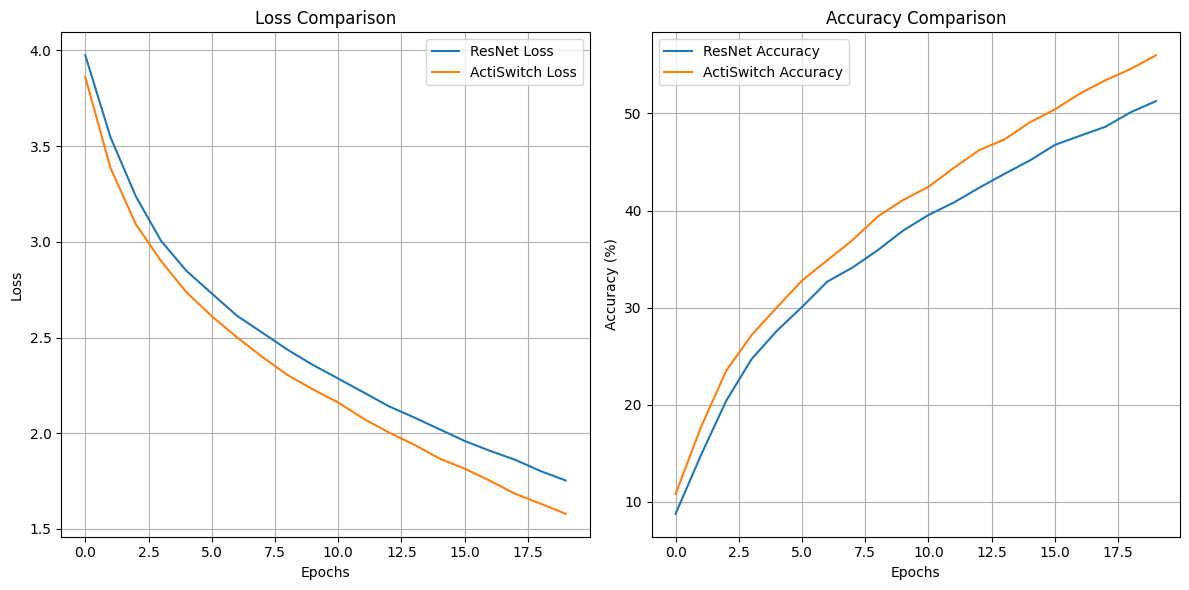

In [40]:
# Plotting function to compare two architectures
def plot_comparison(losses_1, accuracies_1, losses_2, accuracies_2, model_name_1="ResNet", model_name_2="ActiSwitch"):
    # Plot Losses
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(losses_1, label=f'{model_name_1} Loss')
    plt.plot(losses_2, label=f'{model_name_2} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Comparison')
    plt.grid(True)
    plt.legend()

    # Plot Accuracies
    plt.subplot(1, 2, 2)
    plt.plot(accuracies_1, label=f'{model_name_1} Accuracy')
    plt.plot(accuracies_2, label=f'{model_name_2} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy Comparison')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_comparison(losses_1, accuracies_1, losses_2, accuracies_2, model_name_1="ResNet", model_name_2="ActiSwitch")